# Question 3 -
Train a Pure CNN with less than 10000 trainable parameters using the MNIST
Dataset having minimum validation accuracy of 99.40%
Note -
1. Code comments should be given for proper code understanding.
2. Implement in both PyTorch and Tensorflow respectively

PyTorch

# Preparing Data

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt

BATCH_SIZE = 50

train_data = torchvision.datasets.MNIST(
             root='./mnist/',
             train=True,
             transform=torchvision.transforms.ToTensor(),
             download= True,
             )

# Dataset Loader (Input Pipline)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

#Data.DataLoader(dataset,batch_size=1, shuffle=False, sampler=None, num_workers=0, collate_fn=<function default_collate>, pin_memory=False, drop_last=False)

test_data = torchvision.datasets.MNIST(root='./mnist/', train=False)
test_x = Variable(torch.unsqueeze(test_data.data, dim=1)).type(torch.FloatTensor)
test_y = test_data.targets

100%|██████████| 9912422/9912422 [00:00<00:00, 103713959.53it/s]


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 30051027.99it/s]


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26630207.03it/s]


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5070675.74it/s]


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



In [2]:
# Check the dataset
print(train_data.data.size())
print(train_data.targets.size())

torch.Size([60000, 28, 28])
torch.Size([60000])


In [3]:
# Check the dataset
print(train_data)
print('\n')
print(test_data)
print('\n')
print(train_loader)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mnist/
    Split: Train
    StandardTransform
Transform: ToTensor()


Dataset MNIST
    Number of datapoints: 10000
    Root location: ./mnist/
    Split: Test




Images of MNIST

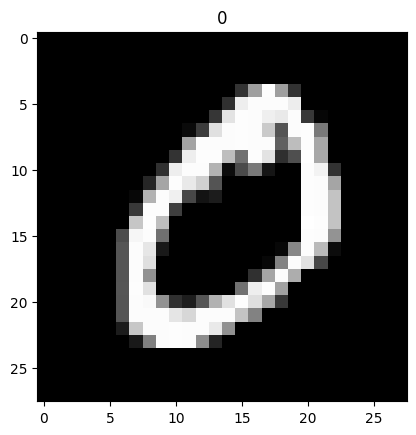

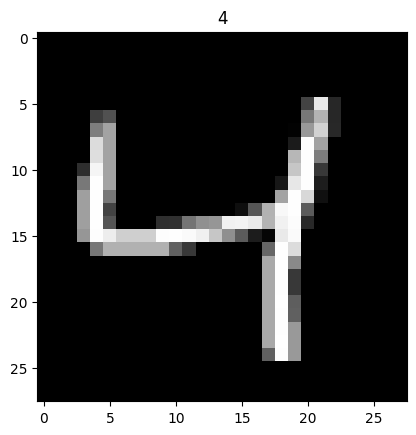

In [4]:
for i in range(1,3):
    plt.imshow(train_data.data[i].numpy(), cmap='gray')
    plt.title('%i' % train_data.targets[i])
    plt.show()

# Initializing CNN

In [5]:
class CNN(nn.Module):
    def __init__(self):  
        super(CNN, self).__init__()  
        self.conv1 = nn.Sequential(  
                     nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
                     nn.ReLU(),
                     nn.MaxPool2d(kernel_size=2) # (16,14,14)
                     )

        self.conv2 = nn.Sequential( # (16,14,14)
                     nn.Conv2d(16, 32, 5, 1, 2), # (32,14,14)
                     nn.ReLU(),
                     nn.MaxPool2d(2) # (32,7,7)
                     )
        self.out = nn.Linear(32*7*7, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1) # (batch, 32,7,7) -> (batch, 32*7*7)
        output = self.out(x)
        return output

In [6]:
# Initialization
cnn = CNN()
print(cnn)

params = list(cnn.parameters())
print('-----')
print(len(params))
print(params[0].size())

EPOCH = 4
BATCH_SIZE = 50
LR = 0.001 # 0.001 is recommended

# Optimizer = Adam
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)

# Loss function = cross-entropy
loss_function = nn.CrossEntropyLoss()

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
-----
6
torch.Size([16, 1, 5, 5])


# Training CNN

In [7]:
def rightness(predictions, labels):
    '''
    Calculate the prediction error rate
    1. "predictions" gives a series of predictions, which is a  "batch_size" x "num_classes" matrix.
    2. "labels" are correct answer
    '''
    pred = torch.max(predictions.data, 1)[1] 
    # For the first dimension of every row (every image), ouput the index of the biggest elements in every row.
    rights = pred.eq(labels.data.view_as(pred)).sum() 
    # Compare the indexs with categories in "labels", and get the accumulated correct numbers.
    return rights, len(labels) 
    # Return the correct numbers and all samples. 

In [8]:
record = [] # A container recording the training accuracies

for epoch in range(EPOCH):  

    train_rights = [] # Record the training accuracies

    for step, (x, y) in enumerate(train_loader):  

        b_x = Variable(x)  
        b_y = Variable(y)  

        cnn.train() 
        # Tell PyTorch that the model is running in training mode (training)

        output = cnn(b_x)  
        loss = loss_function(output, b_y)  
        optimizer.zero_grad() 
        # Indicate optimizer & loss function.
        # Bear in mind that one must zero the gradients last time before back propagation.
 
        loss.backward()  
        optimizer.step()

        right = rightness(output, b_y) # (outputs, labels) = (correct numbers, all samples)
        train_rights.append(right)   


        if step % 200 == 0:

            cnn.eval() 
            # Tell PyTorch that the model is running in evaluation mode (validation/test)

            test_output = cnn(test_x)

            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            test_accuracy = (sum(pred_y == test_y).item() / test_y.size(0)) * 100

            train_r = (sum([tup[0] for tup in train_rights]), sum([tup[1] for tup in train_rights]))
            training_accuracy = 100. * train_r[0].numpy() / train_r[1]

            total_step = len(train_data)//BATCH_SIZE

            print('Epoch [{}/{}], Step [{:4}/{}], Loss: {:.4f} | training accuracy: {:6.2f} % | test accuracy:{:6.2f} %'.format(
                 epoch+1, EPOCH, step+200, total_step, loss.data, training_accuracy, test_accuracy))
            
            record.append((100 - 100. * train_r[0] / train_r[1], 100 - test_accuracy))

Epoch [1/4], Step [ 200/1200], Loss: 2.3019 | training accuracy:  10.00 % | test accuracy: 18.67 %
Epoch [1/4], Step [ 400/1200], Loss: 0.0581 | training accuracy:  82.78 % | test accuracy: 94.83 %
Epoch [1/4], Step [ 600/1200], Loss: 0.1786 | training accuracy:  89.01 % | test accuracy: 95.89 %
Epoch [1/4], Step [ 800/1200], Loss: 0.0918 | training accuracy:  91.67 % | test accuracy: 97.25 %
Epoch [1/4], Step [1000/1200], Loss: 0.0449 | training accuracy:  93.07 % | test accuracy: 97.31 %
Epoch [1/4], Step [1200/1200], Loss: 0.0400 | training accuracy:  93.95 % | test accuracy: 98.11 %
Epoch [2/4], Step [ 200/1200], Loss: 0.1073 | training accuracy:  98.00 % | test accuracy: 97.96 %
Epoch [2/4], Step [ 400/1200], Loss: 0.0412 | training accuracy:  97.98 % | test accuracy: 98.32 %
Epoch [2/4], Step [ 600/1200], Loss: 0.0176 | training accuracy:  98.20 % | test accuracy: 97.97 %
Epoch [2/4], Step [ 800/1200], Loss: 0.0548 | training accuracy:  98.26 % | test accuracy: 98.12 %
Epoch [2/4

# Accuracy on Training & Test Data

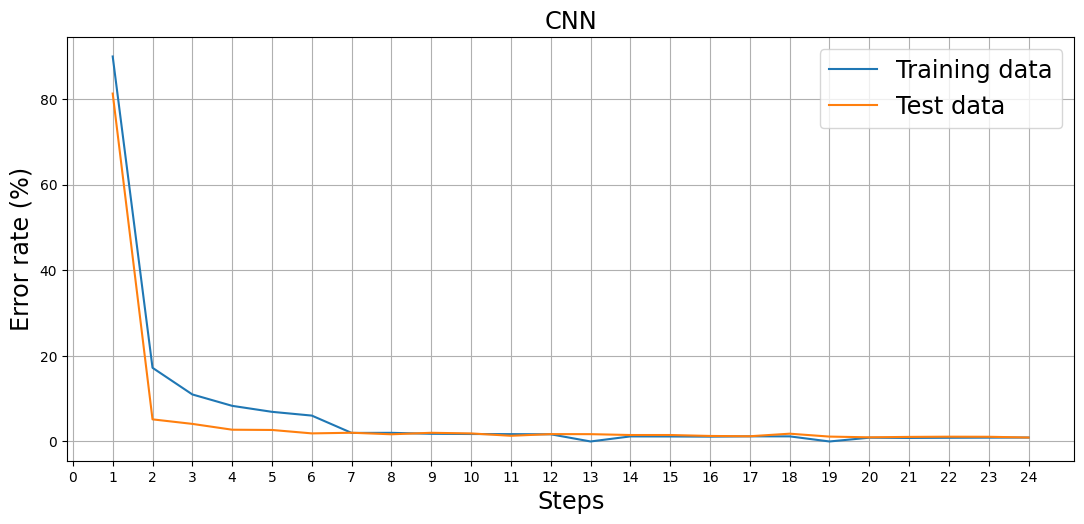

In [17]:
import numpy as np

plt.figure(figsize = (13, 5.5))
train_error, test_error = [k[0] for k in record], [k[1] for k in record]
# "record" records the (training error rate, test error rate) in each step
plt.plot(list(range(1,25)), train_error, label= "Training data") 
plt.plot(list(range(1,25)), test_error, label= "Test data") 

plt.xticks(range(0, 25, 1)) 

plt.xlabel('Steps', fontsize = 'xx-large') # Change font size
plt.ylabel('Error rate (%)')
plt.ylabel('Error rate (%)', fontsize = 'xx-large') # Change font size
plt.title('CNN', fontname='DejaVu Sans', fontsize = 'xx-large') # Change font size

plt.grid() # Simply add grid by default
plt.legend(fontsize = 'xx-large',  loc= 'upper right')
plt.show()

In [14]:
print('Accuracy of the CNN on the 60000 training images: %.4f %%' % 
      (100 - record[17][0]))

print('Accuracy of the CNN on the 10000 test     images: %.4f %%' % 
      (100 - record[17][1]))

Accuracy of the CNN on the 60000 training images: 98.8092 %
Accuracy of the CNN on the 10000 test     images: 98.1800 %


# Predictions on Test Data

In [15]:
test_output = cnn(test_x[:20])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()

print('Prediction number of test data:', pred_y[:20])
print('Real       number of test data:', test_y[:20].numpy())

Prediction number of test data: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
Real       number of test data: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]


# Model Saving

In [16]:
torch.save(cnn.state_dict(), 'ML14_CNN_parameter.pkl') # Save the parameters
torch.save(cnn, 'ML14_CNN_whole_model.pkl') # Save the whole model 

# Tensorflow

In [2]:
# baseline cnn model for mnist
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD

In [3]:
# load dataset
(trainX, trainY), (testX, testY) = mnist.load_data()
# reshape dataset to have a single channel
trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))

In [4]:
# one hot encode target values
from keras.utils import to_categorical
trainY = to_categorical(trainY)
testY = to_categorical(testY)

In [5]:
# load train and test dataset
def load_dataset():
  # load dataset
  (trainX, trainY), (testX, testY) = mnist.load_data()
  # reshape dataset to have a single channel
  trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
  testX = testX.reshape((testX.shape[0], 28, 28, 1))
  # one hot encode target values
  trainY = to_categorical(trainY)
  testY = to_categorical(testY)
  return trainX, trainY, testX, testY

In [6]:
# scale pixels
def prep_pixels(train, test):
  # convert from integers to floats
  train_norm = train.astype('float32')
  test_norm = test.astype('float32')
  # normalize to range 0-1
  train_norm = train_norm / 255.0
  test_norm = test_norm / 255.0
  # return normalized images
  return train_norm, test_norm

In [7]:
# define cnn model
def define_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(10, activation='softmax'))
  # compile model
  opt = SGD(learning_rate=0.01, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [8]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
  scores, histories = list(), list()
  # prepare cross validation
  kfold = KFold(n_folds, shuffle=True, random_state=1)
  # enumerate splits
  for train_ix, test_ix in kfold.split(dataX):
  # define model
    model = define_model()
    # select rows for train and test
    trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
    # fit model
    history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=0)
    print('> %.3f' % (acc * 100.0))
    # stores scores
    scores.append(acc)
    histories.append(history)
    return scores, histories

In [9]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
  for i in range(len(histories)):
  # plot loss
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='orange', label='test')
    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(histories[i].history['accuracy'], color='blue', label='train')
    plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    plt.show()

In [10]:
# summarize model performance
def summarize_performance(scores):
  # print summary
  print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
  # box and whisker plots of results
  plt.boxplot(scores)
  plt.show()

> 98.583


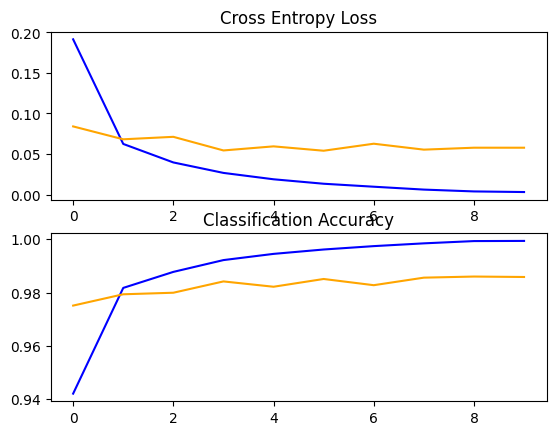

Accuracy: mean=98.583 std=0.000, n=1


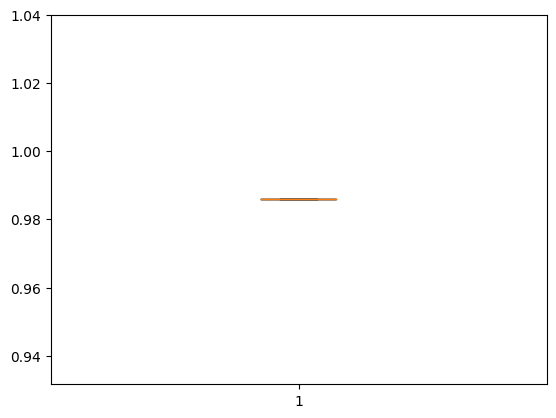

In [11]:
# run the test harness for evaluating a model
def run_test_harness():
  # load dataset
  trainX, trainY, testX, testY = load_dataset()
  # prepare pixel data
  trainX, testX = prep_pixels(trainX, testX)
  # evaluate model
  scores, histories = evaluate_model(trainX, trainY)
  # learning curves
  summarize_diagnostics(histories)
  # summarize estimated performance
  summarize_performance(scores)
 
# entry point, run the test harness
run_test_harness()